In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_utkface_dataset(dataset_path, output_base_path):
    image_paths = []
    gender_labels = []

    for filename in os.listdir(dataset_path):
        image_path = os.path.join(dataset_path, filename)
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        try:
            _, gender, _, _ = filename.split('_')
            image_paths.append(image_path)
            gender_labels.append(int(gender))
        except:
            print(f"Format invalide : {filename}")

    if not image_paths:
        raise ValueError("Aucune image valide trouvée.")

    df = pd.DataFrame({'image': image_paths, 'gender': gender_labels})

    x_train, x_temp, y_train, y_temp = train_test_split(df['image'], df['gender'], test_size=0.4, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_base_path, split, 'male'), exist_ok=True)
        os.makedirs(os.path.join(output_base_path, split, 'female'), exist_ok=True)

    def copy_images_by_gender(image_paths, labels, split_type):
        for img_path, gender in zip(image_paths, labels):
            gender_folder = 'male' if gender == 0 else 'female'
            dest_folder = os.path.join(output_base_path, split_type, gender_folder)
            if os.path.exists(img_path):
                shutil.copy(img_path, dest_folder)

    copy_images_by_gender(x_train, y_train, 'train')
    copy_images_by_gender(x_val, y_val, 'val')
    copy_images_by_gender(x_test, y_test, 'test')

    return df, (x_train.values, x_val.values, x_test.values), (y_train.values, y_val.values, y_test.values)


In [2]:
import os

dataset_path = '/kaggle/input/utk-face/UTKFace'
output_path = 'utk2/final_dataset'

os.makedirs(output_path, exist_ok=True)

df, (x_train, x_test, x_val), (y_train, y_test, y_val) = preprocess_utkface_dataset(dataset_path, output_path)

print("Statistiques du dataset:")
print(f"Nombre total d'images : {len(df)}")
print(f"Images d'entraînement : {len(x_train)}")
print(f"Images de test : {len(x_test)}")
print(f"Images de validation : {len(x_val)}")

Format invalide : 61_1_20170109142408075.jpg.chip.jpg
Format invalide : 61_1_20170109150557335.jpg.chip.jpg
Format invalide : 39_1_20170116174525125.jpg.chip.jpg
Statistiques du dataset:
Nombre total d'images : 23705
Images d'entraînement : 14223
Images de test : 4741
Images de validation : 4741


In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    directory="utk2/final_dataset/train",
    class_names=["female", "male"],
    batch_size=None,
    image_size=(128,128),
)

val_ds = image_dataset_from_directory(
    directory="utk2/final_dataset/val",
    class_names=["female", "male"],
    batch_size=None,
    image_size=(128,128),
)

test_ds = image_dataset_from_directory(
    directory="utk2/final_dataset/test",
    class_names=["female", "male"],
    batch_size=None,
    image_size=(128,128),
)

Found 14223 files belonging to 2 classes.
Found 4741 files belonging to 2 classes.
Found 4741 files belonging to 2 classes.


In [4]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
AUTOTUNE = tf.data.AUTOTUNE
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

{0: 7410, 1: 6813}


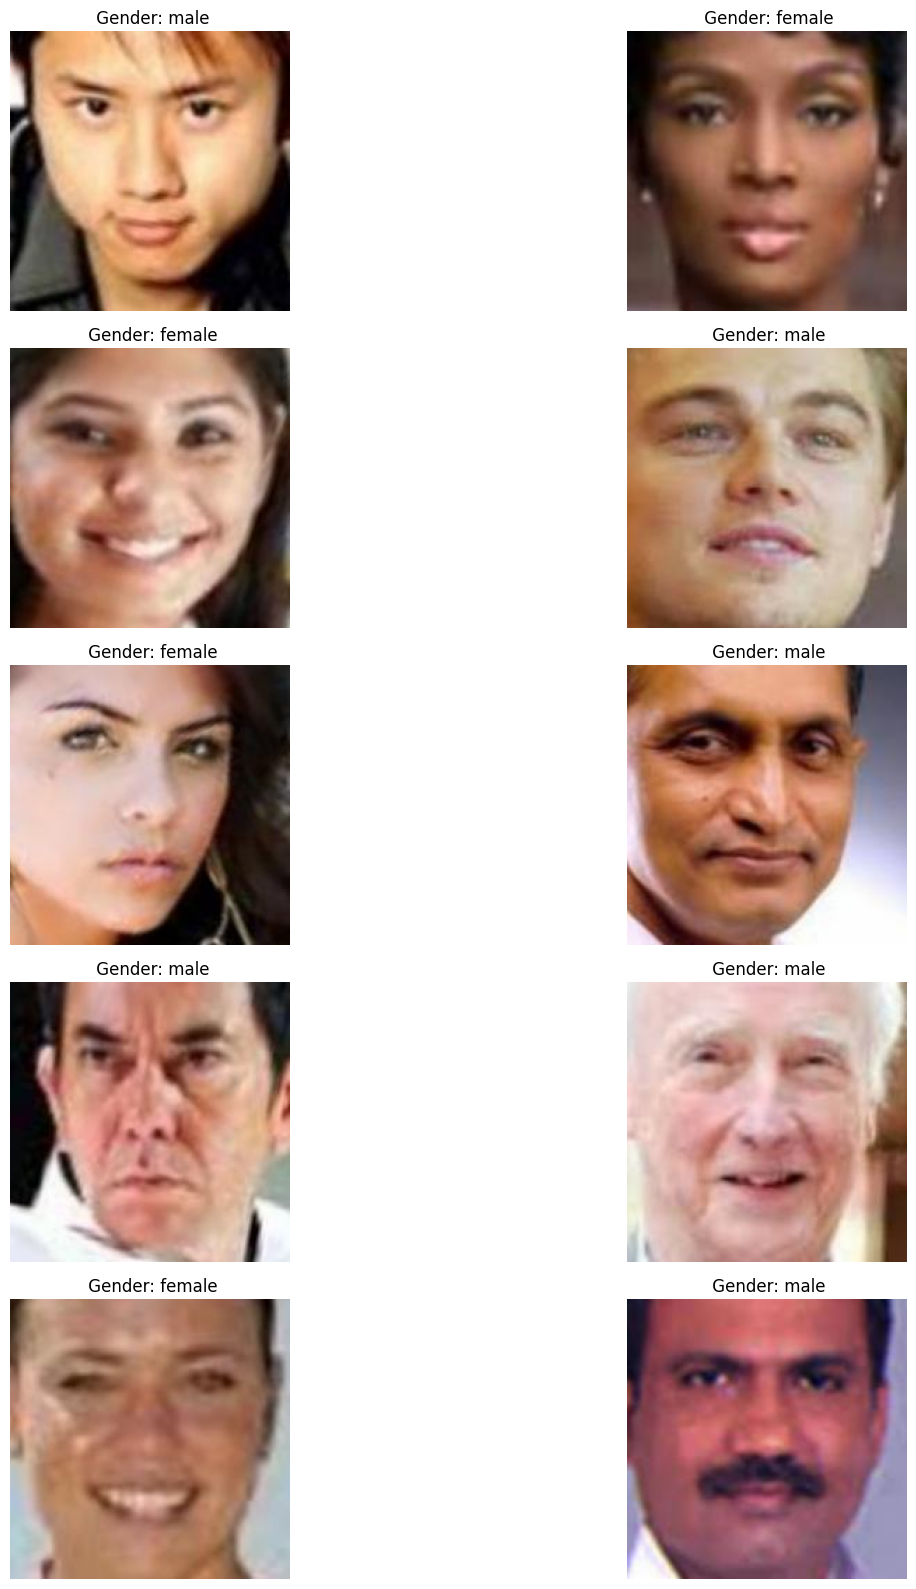

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

gender_dict = {0: 'male', 1: 'female'}

plt.figure(figsize=(16, 16))
files = df.iloc[0:10]

for i, row in files.iterrows():
    plt.subplot(5, 2, i+1)
    img = load_img(row['image'])
    img = np.array(img)
    plt.imshow(img)
    plt.title(f" Gender: {gender_dict[row['gender']]}")
    plt.axis('off')

import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

plt.tight_layout()
plt.show()

In [8]:
labels = {
    1: "female",
    0: "male"
}

In [9]:
train_iter = iter(train_ds)

In [10]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [11]:
image, label = next(train_iter)
print("Shape of the first image in the training dataset: ", image.shape)
print("Class of the first image in the training dataset: ", label)


Shape of the first image in the training dataset:  (128, 128, 3)
Class of the first image in the training dataset:  tf.Tensor(1, shape=(), dtype=int32)


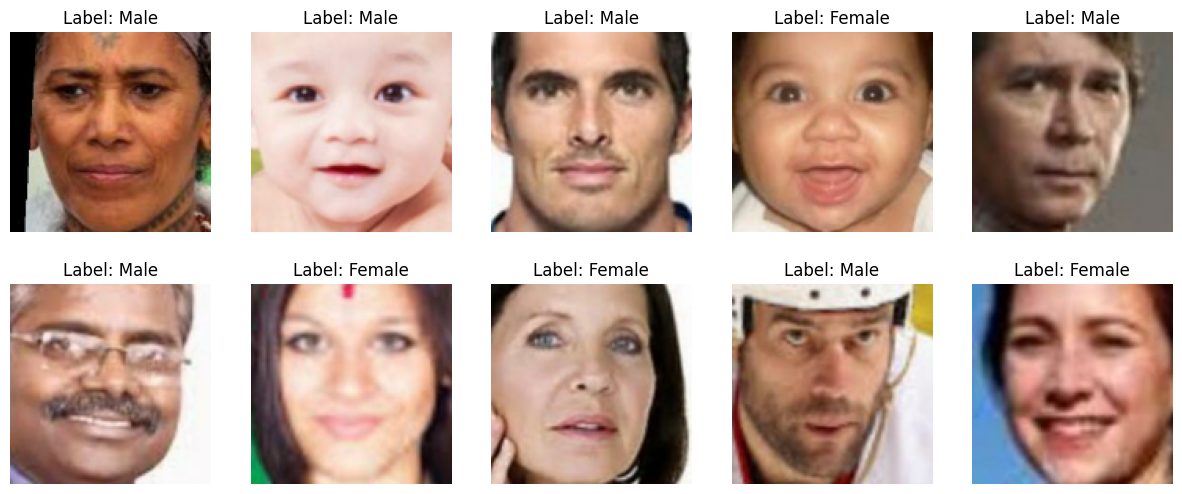

In [12]:
import matplotlib.pyplot as plt

labels = ["Female", "Male"]
train_iter = iter(train_ds)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    image, label = next(train_iter)

    axes[i].imshow(image.numpy() / 255.0) 
    axes[i].set_title(f"Label: {labels[int(label.numpy())]}")
    axes[i].axis('off')

In [13]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [14]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [15]:
import tensorflow as tf

def preprocess_utkface(image, label, size=(100, 100), mode='train'):
    if mode == 'train':
        img_crop = tf.image.random_crop(image, size=(96, 96, 3))
        img_resized = tf.image.resize(img_crop, size=size)
        img_flip = tf.image.random_flip_left_right(img_resized)
        return img_flip / 255.0, tf.cast(label, tf.int32)

    else:
        image_shape = tf.shape(image)
        height, width = image_shape[0], image_shape[1]
        target_height, target_width = 178, 178
        offset_height, offset_width = 20, 0

        if height < target_height + offset_height:
            image = tf.image.resize(image, [target_height + offset_height, width])
            height = target_height + offset_height
        if width < target_width + offset_width:
            image = tf.image.resize(image, [height, target_width + offset_width])
            width = target_width + offset_width 

        img_crop = tf.image.crop_to_bounding_box(image,
                                                 offset_height=offset_height,
                                                 offset_width=offset_width,
                                                 target_height=target_height,
                                                 target_width=target_width)

        img_resized = tf.image.resize(img_crop, size=size)
        return img_resized / 255.0, tf.cast(label, tf.int32)

In [16]:
image_size = (100, 100)
batch_size = 32
buffer_size = 10000
train_ds = train_ds.map(lambda x, y: preprocess_utkface(image=x, label=y, size=image_size, mode='train'))
val_ds = val_ds.map(lambda x, y: preprocess_utkface(image=x, label=y, size=image_size, mode='eval'))

train_ds = train_ds.shuffle(buffer_size=buffer_size).repeat()
train_ds = train_ds.batch(batch_size)

val_ds = val_ds.batch(batch_size)

for image, label in train_ds.take(1):
    print(f"Image shape: {image.shape}, Label shape: {label.shape}")

Image shape: (32, 100, 100, 3), Label shape: (32,)


In [89]:
import numpy as np
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam


def create_model(input_size=(100, 100, 3)):
    inputs = layers.Input(shape=input_size)

    X = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(0.01))(inputs)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.MaxPooling2D((3, 3))(X)

    X = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(X)
    X = layers.MaxPooling2D((2, 2), strides=(2, 2))(X)

    X = layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(X)
    X = layers.MaxPooling2D((2, 2))(X)

    X = layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(X)
    X = layers.MaxPooling2D((2, 2))(X)

    X = layers.Flatten()(X)
    
    dense_1 = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(X)
    dense_2 = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(dense_1)
    dense_3 = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dense_2)
    dropout_1 = layers.Dropout(0.5)(dense_1)
    dropout_2 = layers.Dropout(0.5)(dense_3)

    output_1 = layers.Dense(1, activation='sigmoid', name='gender_output')(dropout_1)

    model = models.Model(inputs=[inputs], outputs=[output_1])

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])

    return model


In [90]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.utils import class_weight


steps_per_epoch = int(np.ceil(buffer_size/batch_size))

model = create_model()
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 98, 98, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 98, 98, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 13, 13, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gender_output (Dense)                │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,600,833 (9.92 MB)

 Trainable params: 2,600,705 (9.92 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
checkpoint_path = "/kaggle/working/checkpoints/model_checkpoint.keras"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

with tf.device('/GPU:0'):
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stopping, model_checkpoint]
)
model = tf.keras.models.load_model(checkpoint_path)
print("Meilleur modèle chargé depuis :", checkpoint_path)


Epoch 1/50
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6342 - loss: 11.0491
Epoch 1: val_loss improved from inf to 4.20349, saving model to /kaggle/working/checkpoints/model_checkpoint.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.6345 - loss: 11.0309 - val_accuracy: 0.7247 - val_loss: 4.2035
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7415 - loss: 3.3121
Epoch 2: val_loss improved from 4.20349 to 1.76243, saving model to /kaggle/working/checkpoints/model_checkpoint.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.7416 - loss: 3.3102 - val_accuracy: 0.7766 - val_loss: 1.7624
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7594 - loss: 1.5659
Epoch 3: val_loss improved from 1.76243 to 1.07465, saving model to /kaggle/working/checkpoints/model_checkpoint.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.7595 - loss: 1.5653 - val_accuracy: 0.7975 - val_loss: 1.0747
Epoch 4/50
313/313 ━━━━━━━━━━

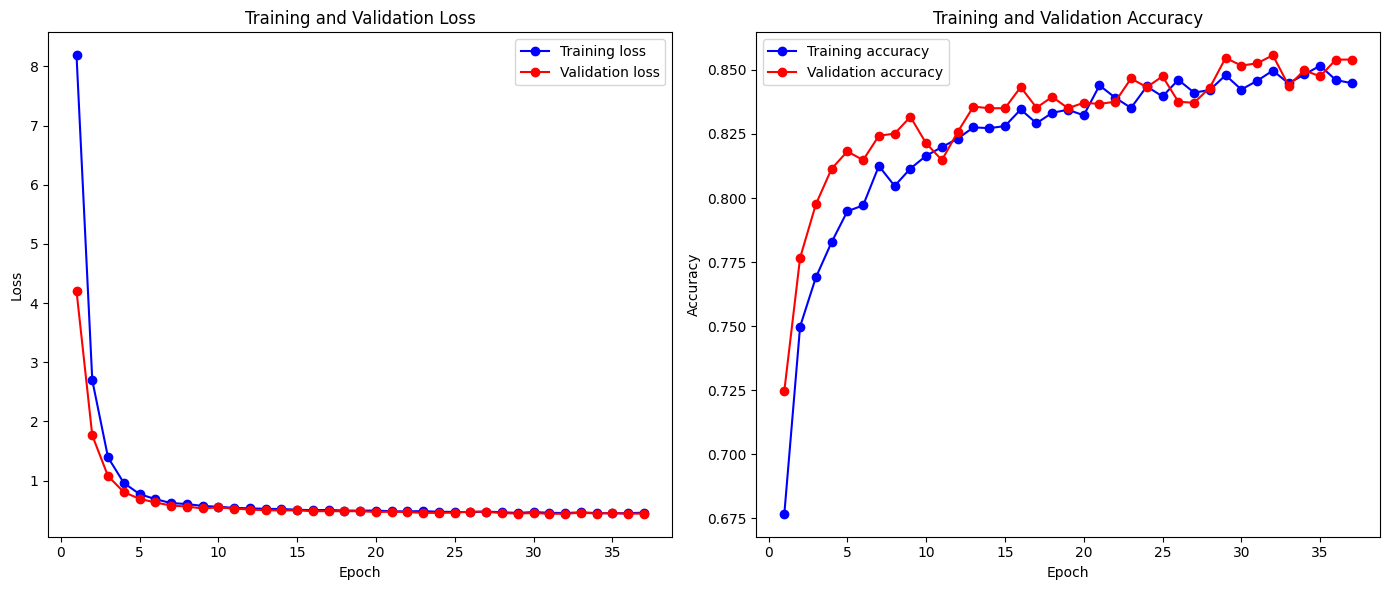

In [92]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(epochs, train_loss, 'bo-', label='Training loss')
ax1.plot(epochs, val_loss, 'ro-', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
ax2.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()


In [93]:
from sklearn.metrics import classification_report

y_pred_proba = model.predict(val_ds)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

y_true = []
for _, labels in val_ds:
    y_true.extend(labels.numpy())

f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1:.4f}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
F1 Score: 0.8619


In [94]:
ds_test = test_ds.map(lambda x, y: preprocess_utkface(x, y, image_size,mode='test')).batch(32)
test_results = model.evaluate(ds_test)
print(f'Test Acc {round(test_results[1]*100,2)}')

f1 = f1_score(y_true, y_pred)
print(f'Test F1 Score: {round(f1, 4)}')

149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8631 - loss: 0.4368
Test Acc 86.33
Test F1 Score: 0.8619


In [95]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

ds_test = test_ds.map(lambda x, y: preprocess_utkface(x, y, image_size, mode='test')).batch(32)

test_results = model.evaluate(ds_test)
print(f'Test Accuracy: {round(test_results[1] * 100, 2)}%')

y_true = []
y_pred = []
y_prob = []

for x, y in ds_test:
    predictions = model.predict(x)  
    y_true.extend(y.numpy())
    y_pred.extend((predictions > 0.5).astype(int))
    y_prob.extend(predictions)

f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

print(f'Test Accuracy: {round(test_results[1] * 100, 2)}%')
print(f'Test F1 Score: {round(f1, 4)}')
print(f'Test Precision: {round(precision, 4)}')
print(f'Test Recall: {round(recall, 4)}')
print(f'Test AUC: {round(auc, 4)}')


149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8631 - loss: 0.4368
Test Accuracy: 86.33%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [103]:
import tensorflow as tf
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def inference(model, image_path, plot=False):
    image = load_image(image_path)
    preprocessed_image, _ = preprocess_utkface(image, label=0, mode='test')
    preprocessed_image = tf.expand_dims(preprocessed_image, axis=0)
    predictions = model.predict(preprocessed_image)
    predicted_class = "Female" if predictions[0][0] < 0.5 else "Male"
    confidence = predictions[0][0] if predictions[0][0] >= 0.5 else 1 - predictions[0][0]
    if plot == False:
      print(f'Predicted class: {predicted_class}')
      print(f'Confidence: {confidence:.4f}')

    else:
      plt.figure(figsize=(8, 8))
      plt.imshow(tf.cast(image, tf.uint8))
      plt.title(f'Predicted class: {predicted_class} ({confidence:.2f})')
      plt.axis('off')
      plt.show()

In [104]:
from tensorflow.keras.models import load_model

model_inference = create_model()
model_inference = load_model("/kaggle/working/checkpoints/model_checkpoint.keras") 

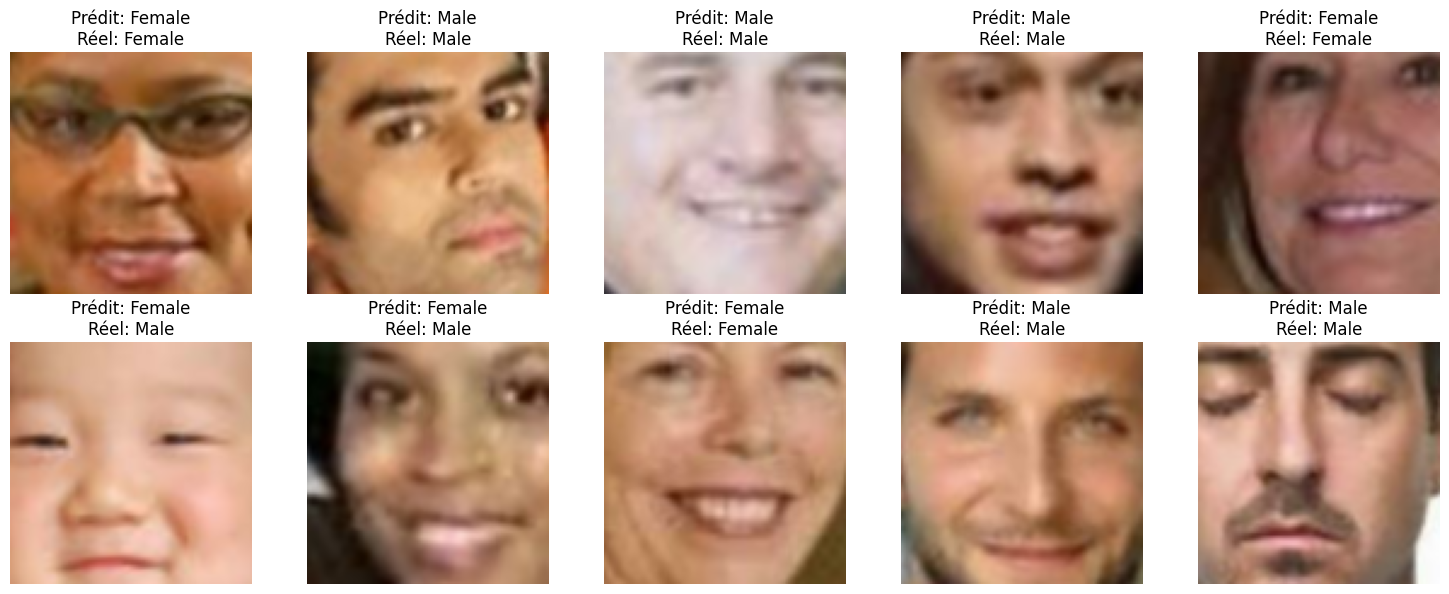

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def visualize_predictions(model, dataset, num_images=10, labels=["Female", "Male"]):
    dataset_iter = iter(dataset)
    
    n_cols = 5
    n_rows = (num_images + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
    axes = axes.flatten() if num_images > 1 else [axes]
    
    for i in range(num_images):
        try:
            images, true_labels = next(dataset_iter)
            
            image = images[0]
            true_label = true_labels[0]
            
            prediction = model.predict(tf.expand_dims(image, 0), verbose=0)
            predicted_class = labels[int(prediction[0, 0] > 0.5)]
            true_class = labels[int(true_label.numpy())]
            
            img_array = image.numpy()
            if img_array.max() > 1:
                img_array = img_array / 255.0

            axes[i].imshow(img_array)
            axes[i].set_title(f"Prédit: {predicted_class}\nRéel: {true_class}")
            axes[i].axis('off')
            
        except StopIteration:
            print(f"Nombre d'images disponibles inférieur à {num_images}")
            break
    
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

try:
    visualize_predictions(model, train_ds, num_images=10)
except NameError:
    print("Erreur : Assurez-vous que 'model' et 'train_ds' sont définis")